# 🩺 Análise Interativa de Sintomas Cardiovasculares

Este notebook utiliza uma abordagem de **IA Híbrida** para triagem médica:
1. **Análise Semântica (spaCy):** Encontra os diagnósticos diferenciais (Junta Médica).
2. **Machine Learning (TF-IDF + Decision Tree):** Classifica o **Grau de Risco**.

## 1. Instalação de Dependências

In [1]:
# Instalação de bibliotecas essenciais e download do modelo em português
!pip install pandas spacy scikit-learn seaborn matplotlib
!python -m spacy download pt_core_news_md

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 7.1 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')


## 2. Carregamento de Bibliotecas e Modelo Base

In [12]:
import pandas as pd
import spacy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from spacy import displacy
# Importação corrigida para compatibilidade com versões recentes do IPython
from IPython.display import display, HTML 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Variáveis globais para os modelos (Prática de modularidade)
nlp = None
vectorizer = None
model = None

try:
    nlp = spacy.load("pt_core_news_md")
    print("✅ Modelo spaCy em Português (pt_core_news_md) carregado.")
except OSError:
    print("❌ ERRO: Modelo 'pt_core_news_md' não encontrado. Execute a célula de instalação.")

✅ Modelo spaCy em Português (pt_core_news_md) carregado.


## 3. Funções de Pré-Processamento e Carregamento de Dados

In [13]:
KNOWLEDGE_BASE_FILE = "../assets/tabela_sintoma_diagnostico_risco.csv"

def spacy_tokenizer(text):
    """Lematiza o texto e remove stopwords para otimizar o TF-IDF."""
    if nlp is None: return []
    doc = nlp(text.lower().strip())
    # Retorna o lemma de tokens que não são stopword, pontuação ou espaço
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space]

def load_knowledge_base(file_path):
    """Carrega a base de conhecimento e pré-processa com spaCy para similaridade."""
    if nlp is None: return None
    try:
        df = pd.read_csv(file_path)
        df.dropna(subset=['Expressão em 1ª Pessoa', 'Grau de Risco'], inplace=True)
        # Cria o objeto spaCy (doc) para cada expressão (para similaridade)
        df['doc'] = list(nlp.pipe(df['Expressão em 1ª Pessoa'].astype(str)))
        print(f"✅ Base de conhecimento de {len(df)} sintomas carregada.")
        return df
    except FileNotFoundError:
        print(f"❌ Erro: Arquivo não encontrado em '{file_path}'")
        return None
    except KeyError:
        print("❌ Erro: Colunas esperadas não encontradas no CSV.")
        return None

knowledge_base_df = load_knowledge_base(KNOWLEDGE_BASE_FILE)

✅ Base de conhecimento de 94 sintomas carregada.


## 4. Função de Treinamento e Avaliação do Modelo ML (Risco)

In [14]:
def train_and_evaluate_model(df):
    global vectorizer, model
    
    if df is None or df.empty: return False

    # 1. Preparação dos Dados
    X = df['Expressão em 1ª Pessoa']
    y = df['Grau de Risco']
    
    # 2. Vetorização com Tokenizer Otimizado (Lematização/Stopwords)
    vectorizer = TfidfVectorizer(max_features=1000, tokenizer=spacy_tokenizer)
    X_tfidf = vectorizer.fit_transform(X)
    
    # 3. Divisão dos Dados (Treino e Teste)
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
    print(f"\n✅ Dados de ML prontos: Treino={X_train.shape}, Teste={X_test.shape}")

    # 4. Treinamento do Modelo (Decision Tree com peso balanceado para classes de risco)
    model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    print("✅ Modelo de Árvore de Decisão treinado.")
    
    # 5. Avaliação
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n🎯 Acurácia no Teste: {accuracy:.2f}")
    print("\n📊 Relatório de Classificação:\n", classification_report(y_test, y_pred, zero_division=0))
    
    # 6. Plot da Matriz de Confusão
    conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(8, 6))
    classes_sorted = sorted(model.classes_)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes_sorted, yticklabels=classes_sorted)
    plt.title('Matriz de Confusão do Modelo de Risco')
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.show()
    
    return True


## 5. Funções de Análise Semântica (Junta Médica) e Previsão ML

In [15]:
def analisar_sintoma_e_discutir(frase_usuario, base_conhecimento, limiar_similaridade=0.65):
    """Realiza a análise semântica e imprime a 'Junta Médica' (NLP)."""
    if base_conhecimento is None or nlp is None: return

    doc_usuario = nlp(frase_usuario.strip().lower())
    try:
        similarities = np.array([doc_usuario.similarity(kb_doc) for kb_doc in base_conhecimento['doc']])
    except ValueError:
        print("❌ ERRO: A similaridade não pode ser calculada.")
        return

    top_indices = np.argsort(similarities)[-3:][::-1]
    maior_similaridade = similarities[top_indices[0]]
    
    print(f"\n--- Análise Semântica da Frase: '{frase_usuario}' ---")

    if maior_similaridade < limiar_similaridade:
        print(f"⚠️ Não foi possível identificar um sintoma correspondente (Similaridade Máxima: {maior_similaridade:.2f}).")
        return

    resultados = [base_conhecimento.iloc[i] for i in top_indices]
    scores = [similarities[i] for i in top_indices]
    emojis = ["✅ 1º", "🥈 2º", "🥉 3º"]

    print("\n*** Hipóteses de Diagnóstico Diferencial ***")
    for i, (res, score) in enumerate(zip(resultados, scores)):
        # Regra de filtro para o 2º e 3º diagnóstico
        if i > 0 and score < limiar_similaridade * 0.85: continue
        print(f"{emojis[i]} Hipótese (Similaridade: {score:.2f}):")
        print(f"   - Sintoma: {res['Sintoma Cardiovascular']}")
        print(f"   - Risco: {res['Grau de Risco']}")
        print(f"   - Diagnóstico Principal: {res['Diagnóstico Cardíaco Principal Associado']}")

    print("\n" + "="*15 + " 🩺 DISCUSSÃO DA JUNTA MÉDICA " + "="*15)
    principal = resultados[0]
    print(f"\n**Hipótese Principal:** A descrição aponta para **{principal['Diagnóstico Cardíaco Principal Associado']}** (Risco: {principal['Grau de Risco']}).")

    if len(resultados) > 1 and scores[1] >= limiar_similaridade * 0.85:
        secundario = resultados[1]
        print(f"**Diagnóstico Diferencial:** Deve-se considerar **{secundario['Diagnóstico Cardíaco Principal Associado']}**, pois os sintomas podem se sobrepor.")

    print("**Recomendação:** Aprofundar a anamnese e realizar exames complementares (ECG, marcadores cardíacos) para confirmação.")
    print("="*58 + '\n')


def prever_risco_ml(frase):
    """Recebe uma frase e retorna a previsão de risco do modelo ML."""
    if model is None or vectorizer is None: return "'Modelo ML não treinado' (Confiança: 0.00)"
    if not frase.strip(): return "'Frase vazia' (Confiança: 1.00)"
    
    # Transforma a frase usando o vectorizer com o spacy_tokenizer
    frase_tfidf = vectorizer.transform([frase])
    
    if frase_tfidf.nnz == 0:
        return "'Indefinido' (Confiança: 0.00 - Vocabulário não encontrado)"

    previsao = model.predict(frase_tfidf)
    probabilidade = model.predict_proba(frase_tfidf)
    max_prob = np.max(probabilidade)
    
    return f"'{previsao[0]}' (Confiança: {max_prob:.2f})"


## 6. Bloco de Execução Principal (Treinamento, Teste e POC)


--- INICIANDO TREINAMENTO E AVALIAÇÃO DO ML ---


/home/brunoconter/.local/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



✅ Dados de ML prontos: Treino=(75, 257), Teste=(19, 257)
✅ Modelo de Árvore de Decisão treinado.

🎯 Acurácia no Teste: 0.68

📊 Relatório de Classificação:
               precision    recall  f1-score   support

  Alto Risco       0.80      0.57      0.67         7
 Baixo Risco       0.50      0.25      0.33         4
 Médio Risco       0.67      1.00      0.80         8

    accuracy                           0.68        19
   macro avg       0.66      0.61      0.60        19
weighted avg       0.68      0.68      0.65        19



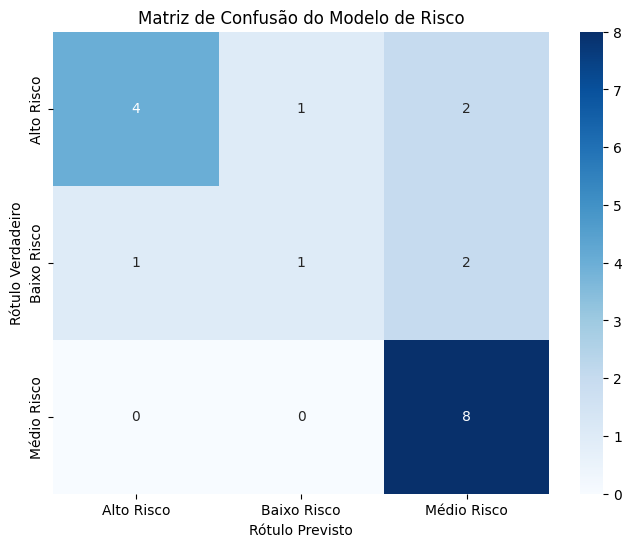


--- 🧪 TESTE RÁPIDO: PREVISÃO DE RISCO PARA TODOS OS EXEMPLOS ---
Frase: "Sinto um peso enorme no peito, parece que tem um elefante se..." -> Risco: 'Médio Risco' (Confiança: 1.00)
Frase: "A dor do peito irradiou para o braço esquerdo e o pescoço." -> Risco: 'Médio Risco' (Confiança: 1.00)
Frase: "Estou com uma queimação forte no meio do peito que não é azi..." -> Risco: 'Alto Risco' (Confiança: 1.00)
Frase: "Acordei de madrugada com uma dor que parecia um rasgo indo p..." -> Risco: 'Alto Risco' (Confiança: 1.00)
Frase: "Sinto só uma pontada rápida no lado esquerdo quando respiro ..." -> Risco: 'Médio Risco' (Confiança: 1.00)
Frase: "A dor aperta e some quando eu paro de andar, mas volta ao su..." -> Risco: 'Médio Risco' (Confiança: 1.00)
Frase: "Senti um aperto no maxilar e comecei a suar frio de repente." -> Risco: 'Alto Risco' (Confiança: 1.00)
Frase: "Estou com um desconforto na boca do estômago e enjoo." -> Risco: 'Médio Risco' (Confiança: 1.00)
Frase: "A dor começou forte e const

In [16]:
# -----------------------------------------------------
# EXECUÇÃO: TREINAMENTO E AVALIAÇÃO DO MODELO ML
# -----------------------------------------------------
if knowledge_base_df is not None:
    print("\n--- INICIANDO TREINAMENTO E AVALIAÇÃO DO ML ---")
    model_trained = train_and_evaluate_model(knowledge_base_df)
else:
    model_trained = False


# -----------------------------------------------------
# EXECUÇÃO: TESTE INTEGRADO COM 30 EXEMPLOS
# -----------------------------------------------------
# Lista robusta de 30 exemplos de sintomas (Atualizada)
exemplos = [
    # 1. Dor Torácica (Angina e Infarto)
    "Sinto um peso enorme no peito, parece que tem um elefante sentado.",
    "A dor do peito irradiou para o braço esquerdo e o pescoço.",
    "Estou com uma queimação forte no meio do peito que não é azia.",
    "Acordei de madrugada com uma dor que parecia um rasgo indo para as costas.",
    "Sinto só uma pontada rápida no lado esquerdo quando respiro fundo.",
    "A dor aperta e some quando eu paro de andar, mas volta ao subir a escada.",
    "Senti um aperto no maxilar e comecei a suar frio de repente.",
    "Estou com um desconforto na boca do estômago e enjoo.",
    "A dor começou forte e constante há 3 horas e não passou com nada.",
    "Tenho um arrocho no peito quando fico nervoso ou estressado.",

    # 2. Falta de Ar (Dispneia e Insuficiência Cardíaca)
    "Estou com falta de ar até em repouso, não consigo respirar direito.",
    "Precisei dormir sentado porque deitado eu sufoco (ortopneia).",
    "Sinto cansaço excessivo e o fôlego está curto ao caminhar um pouco.",
    "Tenho tosse seca e persistente que piora de noite.",
    "Acordo de noite com falta de ar intensa e tenho que correr para a janela.",
    "Minhas pernas estão muito inchadas no fim do dia e a meia aperta.",
    "Estou com a barriga d'água (ascite) e o peso aumentou muito rápido.",
    "Quando me abaixo para amarrar o sapato, sinto falta de ar na hora (bendopneia).",

    # 3. Ritmo e Fluxo (Arritmias, Tontura e Síncope)
    "Sinto um disparo no coração que parece que vai sair pela boca.",
    "Parece que o coração está falhando, dando uns pulos e depois parando.",
    "Eu fiquei tonto e tive a sensação de que ia desmaiar (lipotimia).",
    "Do nada, perdi a consciência e caí no chão (síncope).",
    "Minhas panturrilhas doem muito depois de andar 5 minutos (claudicação).",
    "Meus lábios e dedos estão azulados/roxos (cianose).",

    # 4. Sintomas Inespecíficos e Associados
    "Sinto uma fraqueza generalizada e um cansaço extremo o dia todo.",
    "Minha pressão está sempre 16/10, mesmo tomando o remédio.",
    "Tenho dor de cabeça na nuca que não melhora com remédios simples.",
    "Fico com muito suor frio e ansiedade quando sinto o aperto no peito.",
    "Meus dedos ficam brancos e dormentes no frio intenso (Fenômeno de Raynaud).",
    "Tenho bolinhas de gordura amarelas na pálpebra (xantelasmas)."
]

print("\n" + "="*60)
print("--- 🧪 TESTE RÁPIDO: PREVISÃO DE RISCO PARA TODOS OS EXEMPLOS ---")
print("="*60)
for frase in exemplos:
    risco_previsto = prever_risco_ml(frase)
    print(f"Frase: \"{frase[:60] + '...' if len(frase) > 60 else frase}\" -> Risco: {risco_previsto}")


# Prova de Conceito Completa com um Sintoma Aleatório (Integração NLP + ML)
print("\n" + "="*60)
print("--- 🎲 PROVA DE CONCEITO: TESTE INTEGRADO ALEATÓRIO ---")
print(""" (Mostra Junta Médica e Previsão ML) """)
print("="*60)

if model_trained and knowledge_base_df is not None:
    sintoma_aleatorio = random.choice(exemplos)
    print(f"\nFrase Aleatória: '{sintoma_aleatorio}'")
    
    # 1. Análise Semântica (Junta Médica)
    analisar_sintoma_e_discutir(sintoma_aleatorio, knowledge_base_df)
    
    # 2. Previsão com Machine Learning
    risco_previsto = prever_risco_ml(sintoma_aleatorio)
    print(f"🤖 Previsão Final do Modelo ML (Risco de Triagem): {risco_previsto}")
    print("\n" + "="*60 + "\n")
else:
    print("❌ Treinamento do modelo falhou ou base não carregada. Pule a POC.")


## 7. Análise Detalhada (Interpretabilidade da IA)

In [41]:
if knowledge_base_df is not None and len(exemplos) > 0:
    # Escolhe uma frase aleatória para análise
    frase_para_analise = random.choice(exemplos)
    
    print(f"Frase em Análise: '{frase_para_analise}'")
    print("\n" + "-"*30)
    # Roda a previsão do modelo de ML
    risco_previsto = prever_risco_ml(frase_para_analise)
    print(f"Previsão do Modelo: {risco_previsto}")
    print("-"*30)
    
    doc = nlp(frase_para_analise)
else:
    print("❌ Base de conhecimento ou lista de exemplos indisponível. Não é possível prosseguir com a análise detalhada.")

Frase em Análise: 'Senti um aperto no maxilar e comecei a suar frio de repente.'

------------------------------
Previsão do Modelo: 'Alto Risco' (Confiança: 1.00)
------------------------------


### 7.1. Visualização do Processamento de Linguagem Natural (NLP)

In [44]:
if 'doc' in locals():
    # 1. Visualiza as entidades nomeadas (NER)
    print("Visualização de Entidades Nomeadas (NER):")
    
    # Geramos o HTML do displacy forçando 'jupyter=False'. 
    # Isso evita que o displacy tente importar o módulo 'display' de forma incorreta.
    html_content = displacy.render(doc, style='ent', jupyter=False)
    
    # Renderizamos o HTML manualmente usando a função 'display' importada na Célula 2.
    # O 'display' e 'HTML' funcionam corretamente no seu ambiente.
    display(HTML(html_content)) 
    
    print("\nTokens Processados (Lemma e Stopword):")
    for token in doc:
        # Imprime apenas os tokens que não são stopwords, pontuação ou espaço
        if not token.is_stop and not token.is_punct and not token.is_space:
            print(f"  - Token: {token.text.ljust(10)} | Lemma: {token.lemma_.ljust(10)} | Stopword: {token.is_stop}")
else:
    print("Nenhuma frase para análise.")

Visualização de Entidades Nomeadas (NER):



Tokens Processados (Lemma e Stopword):
  - Token: Senti      | Lemma: sentir     | Stopword: False
  - Token: aperto     | Lemma: aperto     | Stopword: False
  - Token: maxilar    | Lemma: maxilar    | Stopword: False
  - Token: comecei    | Lemma: começar    | Stopword: False
  - Token: suar       | Lemma: suar       | Stopword: False
  - Token: frio       | Lemma: frio       | Stopword: False
  - Token: repente    | Lemma: repente    | Stopword: False


### 7.2. Análise do Vetor TF-IDF da Frase (Interpretabilidade ML)

/tmp/ipykernel_35545/3461416804.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score TF-IDF', y='Palavra (Lemma)', data=df_scores.head(10), palette='plasma')


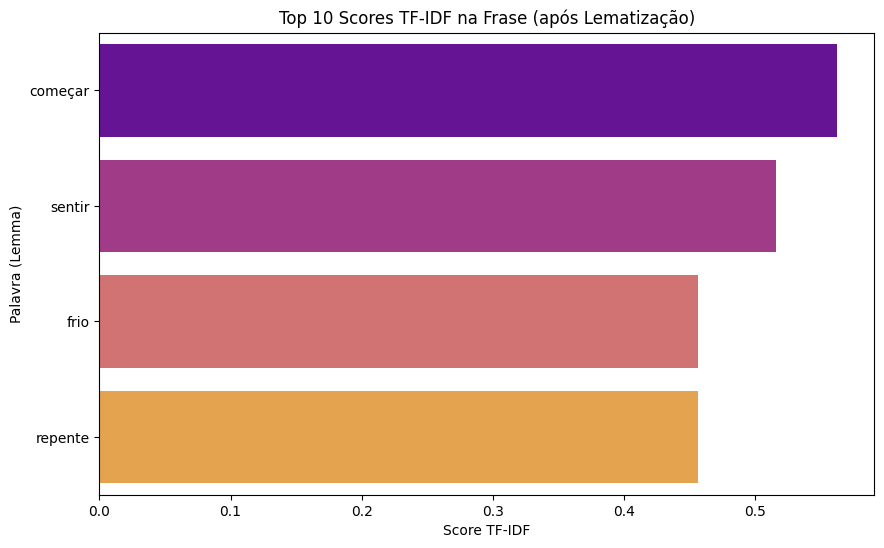

In [45]:
if 'doc' in locals() and vectorizer is not None:
    # Transforma a frase de análise em um vetor TF-IDF (usando o spacy_tokenizer)
    frase_tfidf = vectorizer.transform([frase_para_analise])
    
    # Mapeia os scores
    feature_names = vectorizer.get_feature_names_out()
    feature_indices = frase_tfidf.indices
    scores = frase_tfidf.data
    
    if len(scores) > 0:
        df_scores = pd.DataFrame([(feature_names[i], score) for i, score in zip(feature_indices, scores)], columns=['Palavra (Lemma)', 'Score TF-IDF']).sort_values('Score TF-IDF', ascending=False)

        # Plota o gráfico de barras
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Score TF-IDF', y='Palavra (Lemma)', data=df_scores.head(10), palette='plasma')
        plt.title(f"Top 10 Scores TF-IDF na Frase (após Lematização)")
        plt.xlabel("Score TF-IDF")
        plt.ylabel("Palavra (Lemma)")
        plt.show()
    else:
        print("Nenhuma palavra relevante (após lematização/stopwords) foi encontrada no vocabulário do modelo.")
else:
    print("Modelo de ML ou frase de análise indisponível.")